In [1]:
# import packages for research
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco
import cvxopt as opt
from cvxopt import blas, solvers

plt.style.use('fivethirtyeight')
np.random.seed(777)
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False
solvers.options['show_progress'] = False

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<hr style="border:2px solid #04d9ff">

### 1. Selecting stocks for the portfolio
Stocks were selected based on one specific criteria, i.e. well performing stocks within the solar panel industry. The reason for choosing this criteria is because of the ESG theme.

### 2. Collect daily return data
Data for 10 Korean stocks within KOSPI and KOSDAQ were collected using the TS2000 application.
Collected data will be converted to percent change of daily returns. $$\frac{P_i - P_{i-1}}{P_{i-1}}$$

In [2]:
# importing data to a dataframe and organizing
data = pd.read_csv("데이터.csv", encoding='cp949')
data.drop([0,1,2], inplace=True)
data.rename(columns={'회사명':'Date'}, inplace=True)
data.set_index("Date", inplace=True)
data = data.apply(pd.to_numeric)
data.head()

,나노신소재,대성파인텍,대주전자재료,신성이엔지보통주,아바코,알에스오토메이션,주성엔지니어링,주식회사케이씨씨,코미코,한화솔루션보통주
Date,,,,,,,,,,
2020/05/04,12450,1155,19300,886,6400,7120,5260,159500,24100,13800
2020/05/06,12900,1215,20400,910,6390,7600,5400,157500,25400,14000
2020/05/07,13200,1225,21100,905,6630,7630,5580,157500,26400,14300
2020/05/08,13200,1225,21300,906,6640,7840,5790,157500,26050,14300
2020/05/11,12950,1230,21250,943,6580,7830,5640,153000,27500,14950


Text(0, 0.5, 'daily returns')

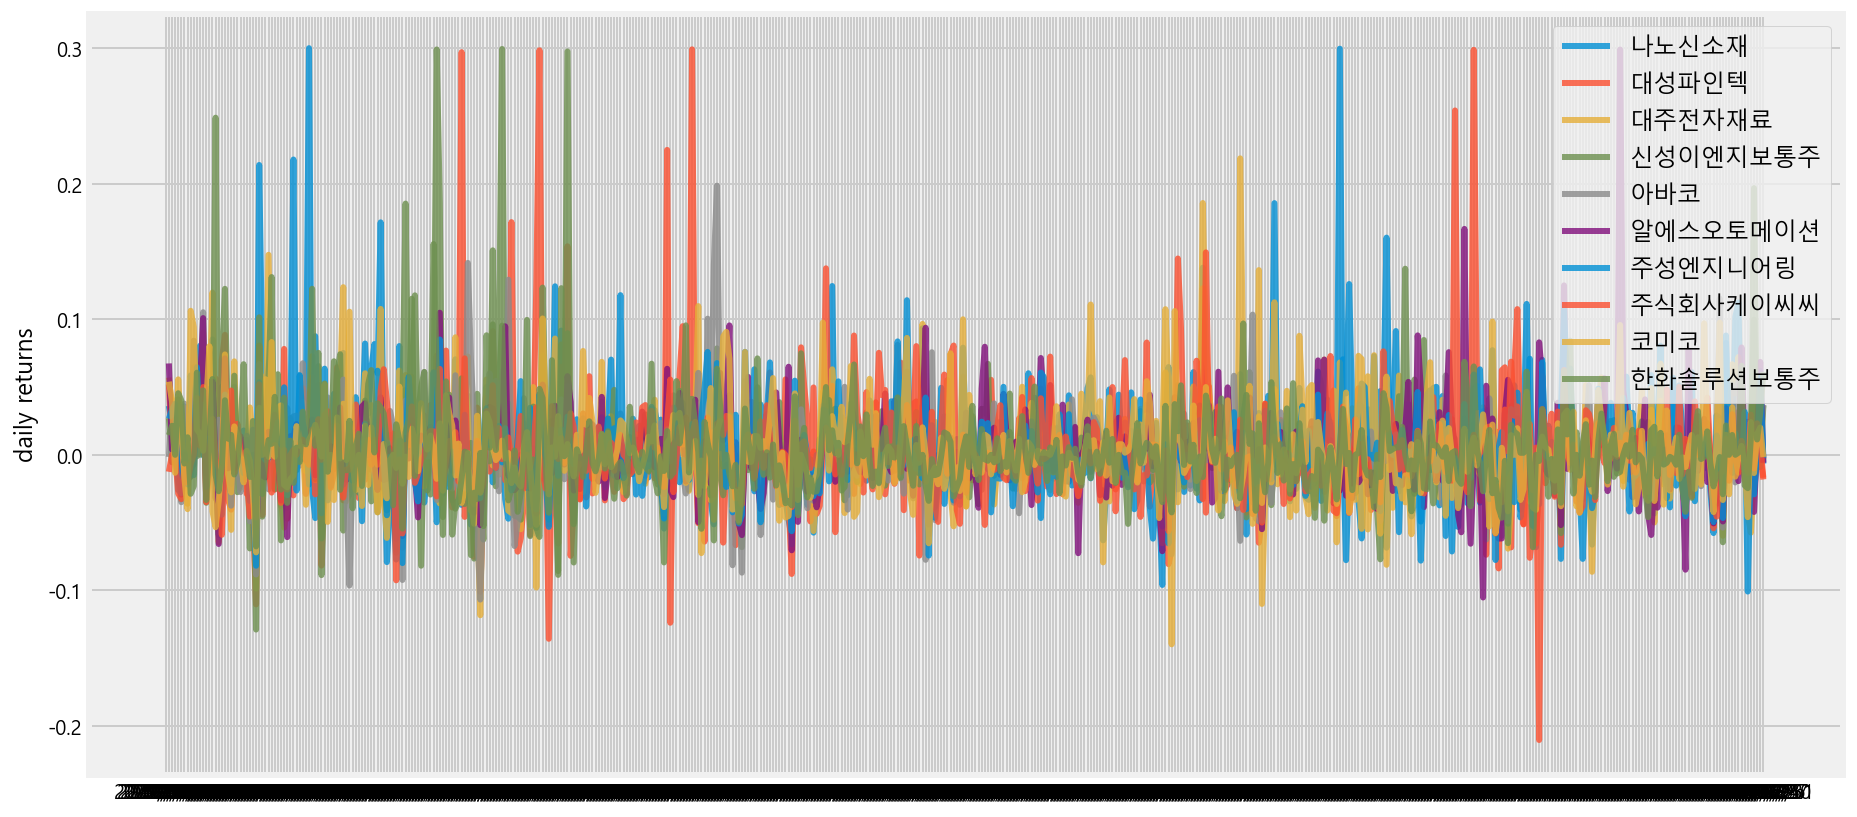

In [3]:
# plot daily percentage change for all stocks
returns = data.pct_change()
plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

<hr style="border:2px solid #04d9ff">

#### 3. Calculating the mean and variance of returns of each stock and constructing the variance-covariance matrix using collected daily return data

In [4]:
# calculate mean of daily returns for each stock
returns.mean()

나노신소재       0.004757
대성파인텍       0.002192
대주전자재료      0.003695
신성이엔지보통주    0.002707
아바코         0.001824
알에스오토메이션    0.002266
주성엔지니어링     0.003249
주식회사케이씨씨    0.002001
코미코         0.002298
한화솔루션보통주    0.002515
dtype: float64

In [5]:
# calculate variance of daily returns for each stock
returns.var()

나노신소재       0.001786
대성파인텍       0.002075
대주전자재료      0.001431
신성이엔지보통주    0.001855
아바코         0.001010
알에스오토메이션    0.001167
주성엔지니어링     0.001102
주식회사케이씨씨    0.000964
코미코         0.001006
한화솔루션보통주    0.000992
dtype: float64

- Variance-Covariance Matrix

$$cov_{x,y} = E[(X – E[X])(Y – E[Y])] = \frac{\sum(x_i – \bar{x})(y_i – \bar{y})}{N-1}$$

In [6]:
# calculate the covariance matrix
cov_matrix = returns.cov()
cov_matrix


,나노신소재,대성파인텍,대주전자재료,신성이엔지보통주,아바코,알에스오토메이션,주성엔지니어링,주식회사케이씨씨,코미코,한화솔루션보통주
나노신소재,0.446424,0.098403,0.255319,0.064266,0.074646,0.073328,0.056790,0.032159,0.072699,0.090965
대성파인텍,0.098403,0.518762,0.085756,0.174629,0.098466,0.085114,0.094673,0.060445,0.065440,0.126831
대주전자재료,0.255319,0.085756,0.357870,0.075844,0.082235,0.079068,0.052520,0.031634,0.080624,0.080178
신성이엔지보통주,0.064266,0.174629,0.075844,0.463671,0.083048,0.081366,0.058470,0.042724,0.053031,0.147379
아바코,0.074646,0.098466,0.082235,0.083048,0.252402,0.067695,0.086133,0.050464,0.053662,0.061944
알에스오토메이션,0.073328,0.085114,0.079068,0.081366,0.067695,0.291816,0.084227,0.058048,0.073453,0.073518
주성엔지니어링,0.056790,0.094673,0.052520,0.058470,0.086133,0.084227,0.275579,0.064946,0.079697,0.073116
주식회사케이씨씨,0.032159,0.060445,0.031634,0.042724,0.050464,0.058048,0.064946,0.240991,0.029747,0.065176
코미코,0.072699,0.065440,0.080624,0.053031,0.053662,0.073453,0.079697,0.029747,0.251580,0.058677
한화솔루션보통주,0.090965,0.126831,0.080178,0.147379,0.061944,0.073518,0.073116,0.065176,0.058677,0.247966


# Correlation Matrix
$$\rho_{x,y} = \frac{\sigma_{x,y}}{\sqrt{\sigma^2_x\sigma^2_y}}$$

Below is a heatmap of the correlation matrix

In [12]:
corr_matrix = returns.corr()

cmap = sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr_matrix.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

C:\Users\pt88\AppData\Local\Temp\ipykernel_11584\1273026432.py:17: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr_matrix.style.background_gradient(cmap, axis=1)\


,나노신소재,대성파인텍,대주전자재료,신성이엔지보통주,아바코,알에스오토메이션,주성엔지니어링,주식회사케이씨씨,코미코,한화솔루션보통주
나노신소재,1.00,0.20,0.64,0.14,0.22,0.20,0.16,0.10,0.22,0.27
대성파인텍,0.20,1.00,0.20,0.36,0.27,0.22,0.25,0.17,0.18,0.35
대주전자재료,0.64,0.20,1.00,0.19,0.27,0.24,0.17,0.11,0.27,0.27
신성이엔지보통주,0.14,0.36,0.19,1.00,0.24,0.22,0.16,0.13,0.16,0.43
아바코,0.22,0.27,0.27,0.24,1.00,0.25,0.33,0.20,0.21,0.25
알에스오토메이션,0.20,0.22,0.24,0.22,0.25,1.00,0.30,0.22,0.27,0.27
주성엔지니어링,0.16,0.25,0.17,0.16,0.33,0.30,1.00,0.25,0.30,0.28
주식회사케이씨씨,0.10,0.17,0.11,0.13,0.20,0.22,0.25,1.00,0.12,0.27
코미코,0.22,0.18,0.27,0.16,0.21,0.27,0.30,0.12,1.00,0.23
한화솔루션보통주,0.27,0.35,0.27,0.43,0.25,0.27,0.28,0.27,0.23,1.00


<hr style="border:2px solid #04d9ff">

### 4. Solve for below items
- Draw the efficient portfolio frontier (show the frontier is a hyperbola)
- Find the globally minimum variance portfolio (weight of each stock, expected return, and variance of GMVP)

- $\footnotesize Given\ R_f = 2\%, solve\ for\ the\ tangent\ portfolio$   (weight for each stock, expected return, and variance of tangent portfolio)

<hr style="border:2px solid gray">

In [15]:

def portfolio_annualised_performance(weights: np.array, mean_returns: np.array, cov_matrix: np.array):
    """Calculate the returns and volatility of the portfolio and annualize them.
    
    Returns standard deviation and expected return of the portfolio.

    Args:
        weights (array): 1 x N matrix of weights for each stock
        mean_returns (array): 1 x N matrix of mean_returns for each stock
        cov_matrix (array): N X N matrix of variance-covariance matrix between stocks.

    Returns:
        tuple: (standard deviation of portfolio, expected return of portfolio)
    """
    returns = ((1 + np.sum( mean_returns*weights )) ** 250) - 1
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(250)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    """Generate portfolios with random weights assigned to each stock.

    Args:
        num_portfolios (int): How many random portfolios to test
        mean_returns (array): 1 x N matrix of mean_returns for each stock
        cov_matrix (array): N X N matrix of variance-covariance matrix between stocks.
        risk_free_rate (float): assign a risk free rate to test portfolio sharpe ratio.

    Returns:
        tuple: ( 3xN matrix -> [numpy array of std, e(r) portfolio, sharpe ratio of portfolio ], list of weights that were randomly assigned.)
    """
    results = np.zeros((3,num_portfolios))
    weights_record = []
    num_stocks = len(mean_returns)
    
    for i in range(num_portfolios):
        weights = np.random.random(num_stocks)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev  # calculate Sharpe ratio and store in results
    return results, weights_record

<hr style="border:2px solid gray">

In the cell above, the functions generate random portfolio, grab the results (portfolio returns, portfolio volatility, portfolio Sharpe ratio) and weights for the corresponding result.
From the cell below, by utilizing the above functions, the display function will locate the highest Sharpe ratio portfolio (tangent portfolio), displaying it as red star sign. Similarly it will locate the minimum volatility portfolio(GMVP), and display it as a green star. Randomly generated portfolios will also be plotted with a color map applied based on the Sharpe ratio. Bluer the colour, higher the Sharpe ratio.

<hr style="border:2px solid gray">

In [16]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=data.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=data.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print ( "Maximum Sharpe Ratio Portfolio Allocation(Tangent Portfolio)\n" )
    print ( "Annualised Return:", round(rp,2) )
    print ( "Annualised Volatility:", round(sdp,2) )
    print ( "\n" )
    print ( max_sharpe_allocation )
    print ( "-"*80 )
    print ( "Minimum Volatility Portfolio Allocation(GMVP)\n" )
    print ( "Annualised Return:", round(rp_min,2) )
    print ( "Annualised Volatility:", round(sdp_min,2) )
    print ( "\n" )
    print ( min_vol_allocation )
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe Ratio(Tangent Portfolio)')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum Volatility(GMVP)')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('Annualised Volatility')
    plt.ylabel('Annualised Returns')
    plt.legend(labelspacing=0.8)

In [17]:
#  Reorganize dataframes needed and set argument variables

returns = data.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0.02

In [18]:
def annualize_return(mean):
    annualised_ret = ((1 + mean) ** 250) - 1
    return annualised_ret

test_return = annualize_return(mean_returns)
test_risk = returns.std() * np.sqrt(250)
test_sharpe = (test_return - .02) / (test_risk)
test_sharpe

나노신소재       3.375022
대성파인텍       0.983963
대주전자재료      2.498450
신성이엔지보통주    1.389073
아바코         1.108559
알에스오토메이션    1.371384
주성엔지니어링     2.343312
주식회사케이씨씨    1.279708
코미코         1.504968
한화솔루션보통주    1.714261
dtype: float64

In [19]:
test_return

나노신소재       2.275020
대성파인텍       0.728701
대주전자재료      1.514628
신성이엔지보통주    0.965867
아바코         0.576936
알에스오토메이션    0.760821
주성엔지니어링     1.250137
주식회사케이씨씨    0.648219
코미코         0.774858
한화솔루션보통주    0.873636
dtype: float64

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation(Tangent Portfolio)

Annualised Return: 1.34
Annualised Volatility: 0.37


            나노신소재  대성파인텍  대주전자재료  신성이엔지보통주   아바코  알에스오토메이션  주성엔지니어링  주식회사케이씨씨  \
allocation  29.17   0.39   13.09      7.29  1.82      8.28    17.83      2.94   

             코미코  한화솔루션보통주  
allocation  4.72     14.46  
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation(GMVP)

Annualised Return: 0.88
Annualised Volatility: 0.3


            나노신소재  대성파인텍  대주전자재료  신성이엔지보통주    아바코  알에스오토메이션  주성엔지니어링  \
allocation   5.32   0.88    6.75      1.46  14.69      9.98     9.35   

            주식회사케이씨씨    코미코  한화솔루션보통주  
allocation     18.16  16.82     16.59  


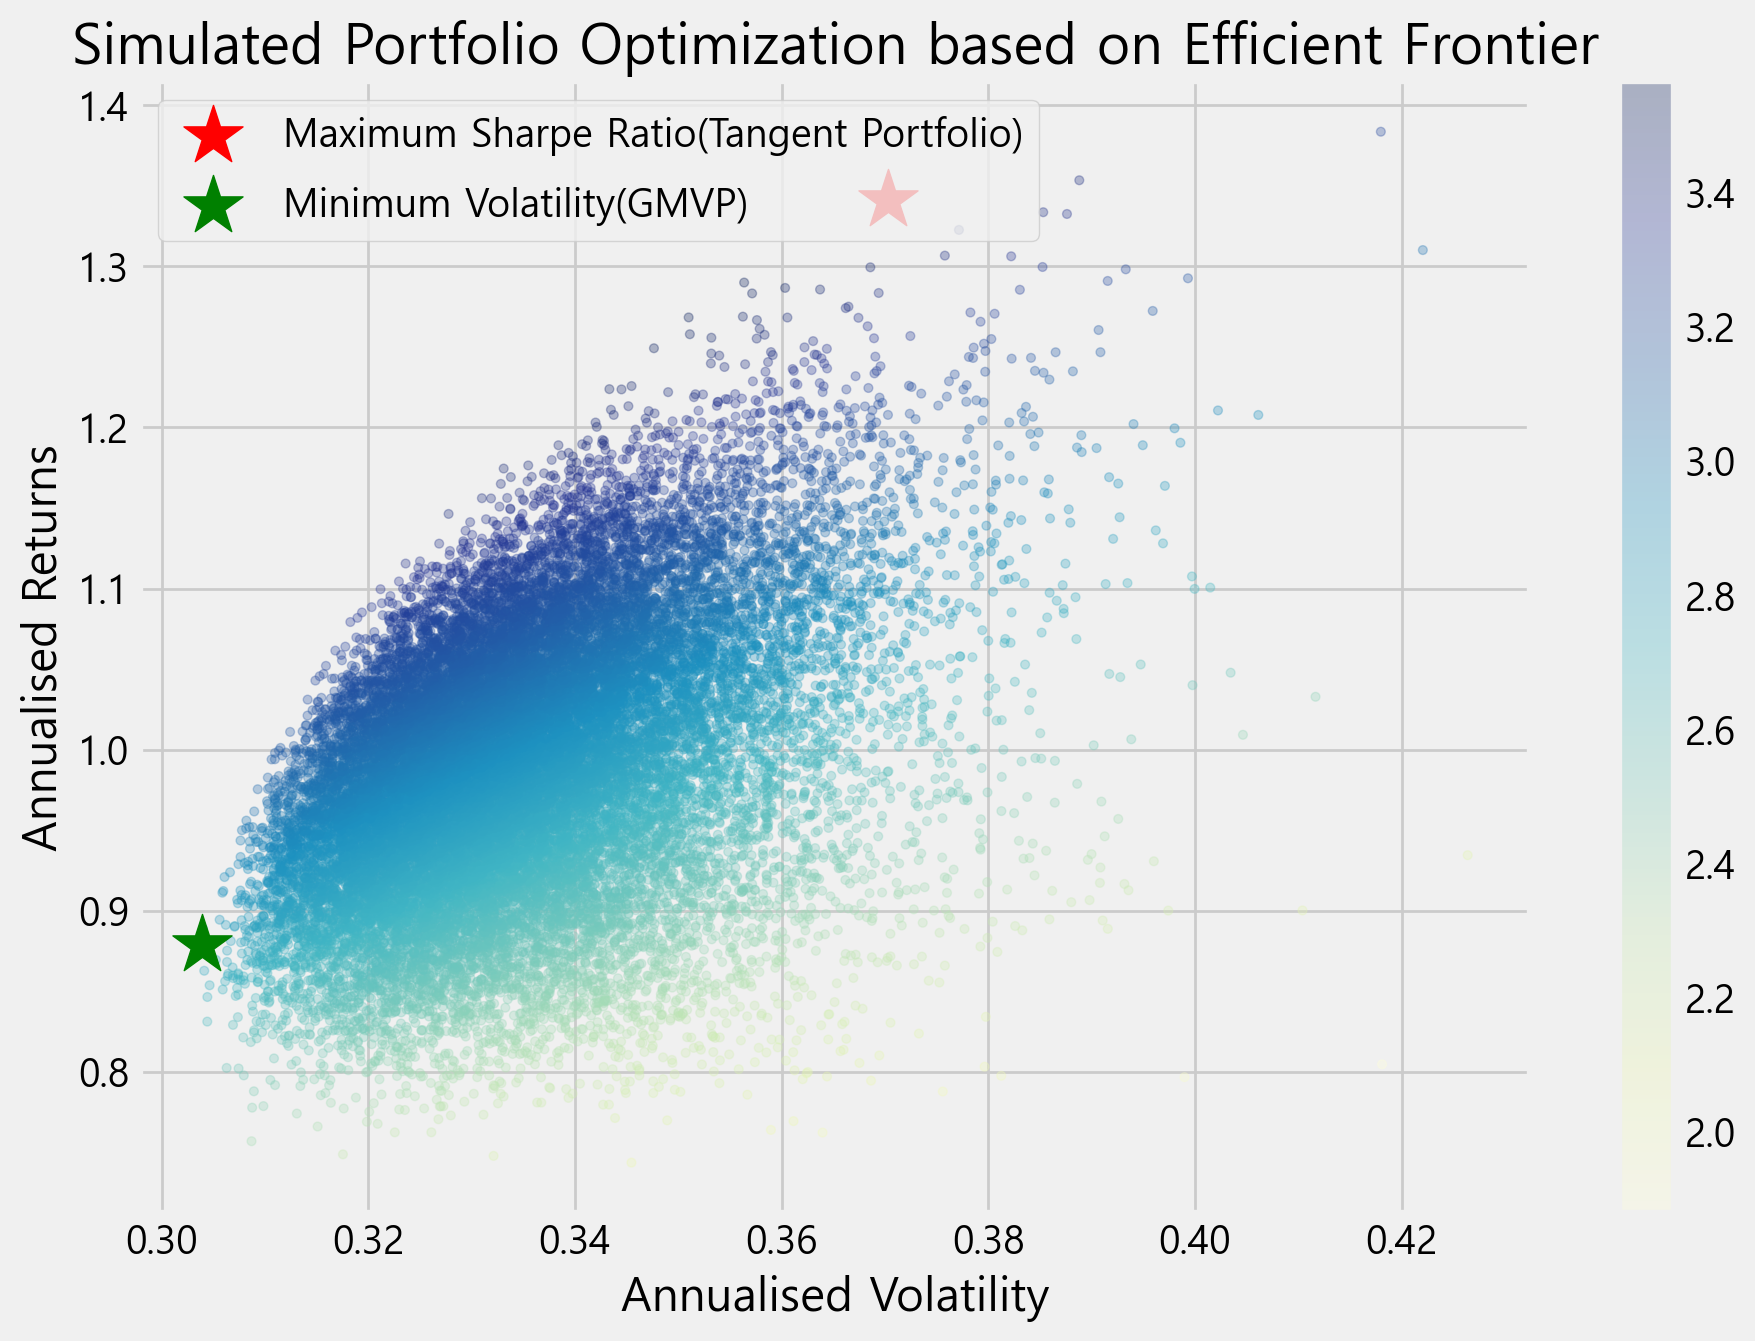

In [12]:
# When portfolio is generated with random weights
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

<hr style="border:2px solid gray">

Instead of randomly generating portfolio weights we can also calculate the tangent portfolio by scipy's optimize function. However, the function does not have 'maximize' ability, instead needs to pass something that should be minimized. We take negative Sharpe ratio and minimize instead, which is equivalent to maximizing positive Sharpe ratio.

$MIN_w \ \ w^T V w$

Below are optimization functions to locate GMVP and tangent portfolio.



In [13]:
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 1000
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    
    return np.asarray(wt), returns, risks




In [14]:
# # Efficient Frontier Portfolios
op_weights, op_returns, op_risks = optimal_portfolio(returns.T.iloc[:,1:].to_numpy())

# # Annualize data
# op_returns = (((np.array(op_returns) + 1) ** 250) - 1)
# op_risks = np.array(op_risks) * np.sqrt(250)

# # Generate Sharpe ratio for optimized portfolios
# op_sharpe = (op_returns - risk_free_rate) / op_risks

In [15]:


def display_simulated_ef_with_line(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate)
    
    # Efficient Frontier Portfolios
    op_weights, op_returns, op_risks = optimal_portfolio(returns.T.iloc[:,1:].to_numpy())
    # Annualize E.F. data
    op_returns = (((np.array(op_returns) + 1) ** 250) - 1)
    op_risks = np.array(op_risks) * np.sqrt(250)
    # Generate Sharpe ratio for optimized portfolios
    op_sharpe = (op_returns - risk_free_rate) / op_risks
    
    # Locate tangent portfolio based on max sharpe ratio
    max_sharpe_idx = np.argmax(op_sharpe)
    sdp, rp = op_risks[max_sharpe_idx], op_returns[max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(op_weights,index=data.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    # Locate minium
    min_vol_idx = np.argmin(op_sharpe)
    sdp_min, rp_min = op_risks[min_vol_idx], op_returns[min_vol_idx]
    min_vol_allocation = pd.DataFrame(op_weights,index=data.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ( "Maximum Sharpe Ratio Portfolio Allocation(Tangent Portfolio)\n" )
    print ( "Annualised Return:", round(rp,2) )
    print ( "Annualised Volatility:", round(sdp,2) )
    print ( "Sharpe Ratio:", round(op_sharpe[max_sharpe_idx], 2) )
    print ( "\n" )
    print ( max_sharpe_allocation )
    print ( "-"*80 )
    print ( "Minimum Volatility Portfolio Allocation(GMVP)\n" )
    print ( "Annualised Return:", round(rp_min,2) )
    print ( "Annualised Volatility:", round(sdp_min,2) )
    print ( "\n" )
    print ( min_vol_allocation )
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe Ratio(Tangent Portfolio)')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum Volatility(GMVP)')
    plt.plot(op_risks, op_returns, color="k", label="Efficient Frontier" )
    
    def cal(slope, intercept):
        # draw capital allocation line by using max sharpe as slope and Rf as intercept
        axes = plt.gca()
        x_vals = np.array(axes.get_xlim())
        y_vals = intercept + slope * x_vals
        plt.plot(x_vals, y_vals, '--', label="Capital Allocation Line")
    cal(op_sharpe[max_sharpe_idx], risk_free_rate)
    
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('Annualised Volatility')
    plt.ylabel('Annualised Returns')
    plt.xlim(right=.5)
    plt.ylim(top=2.0)
    plt.legend(loc='upper left', labelspacing=0.8)
    
    return rp, sdp

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation(Tangent Portfolio)

Annualised Return: 1.67
Annualised Volatility: 0.44
Sharpe Ratio: 3.78


            나노신소재  대성파인텍  대주전자재료  신성이엔지보통주  아바코  알에스오토메이션  주성엔지니어링  주식회사케이씨씨  \
allocation  100.0    0.0     0.0       0.0  0.0       0.0      0.0       0.0   

            코미코  한화솔루션보통주  
allocation  0.0       0.0  
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation(GMVP)

Annualised Return: 0.86
Annualised Volatility: 0.3


            나노신소재  대성파인텍  대주전자재료  신성이엔지보통주  아바코  알에스오토메이션  주성엔지니어링  주식회사케이씨씨  \
allocation  100.0    0.0     0.0       0.0  0.0       0.0      0.0       0.0   

            코미코  한화솔루션보통주  
allocation  0.0       0.0  


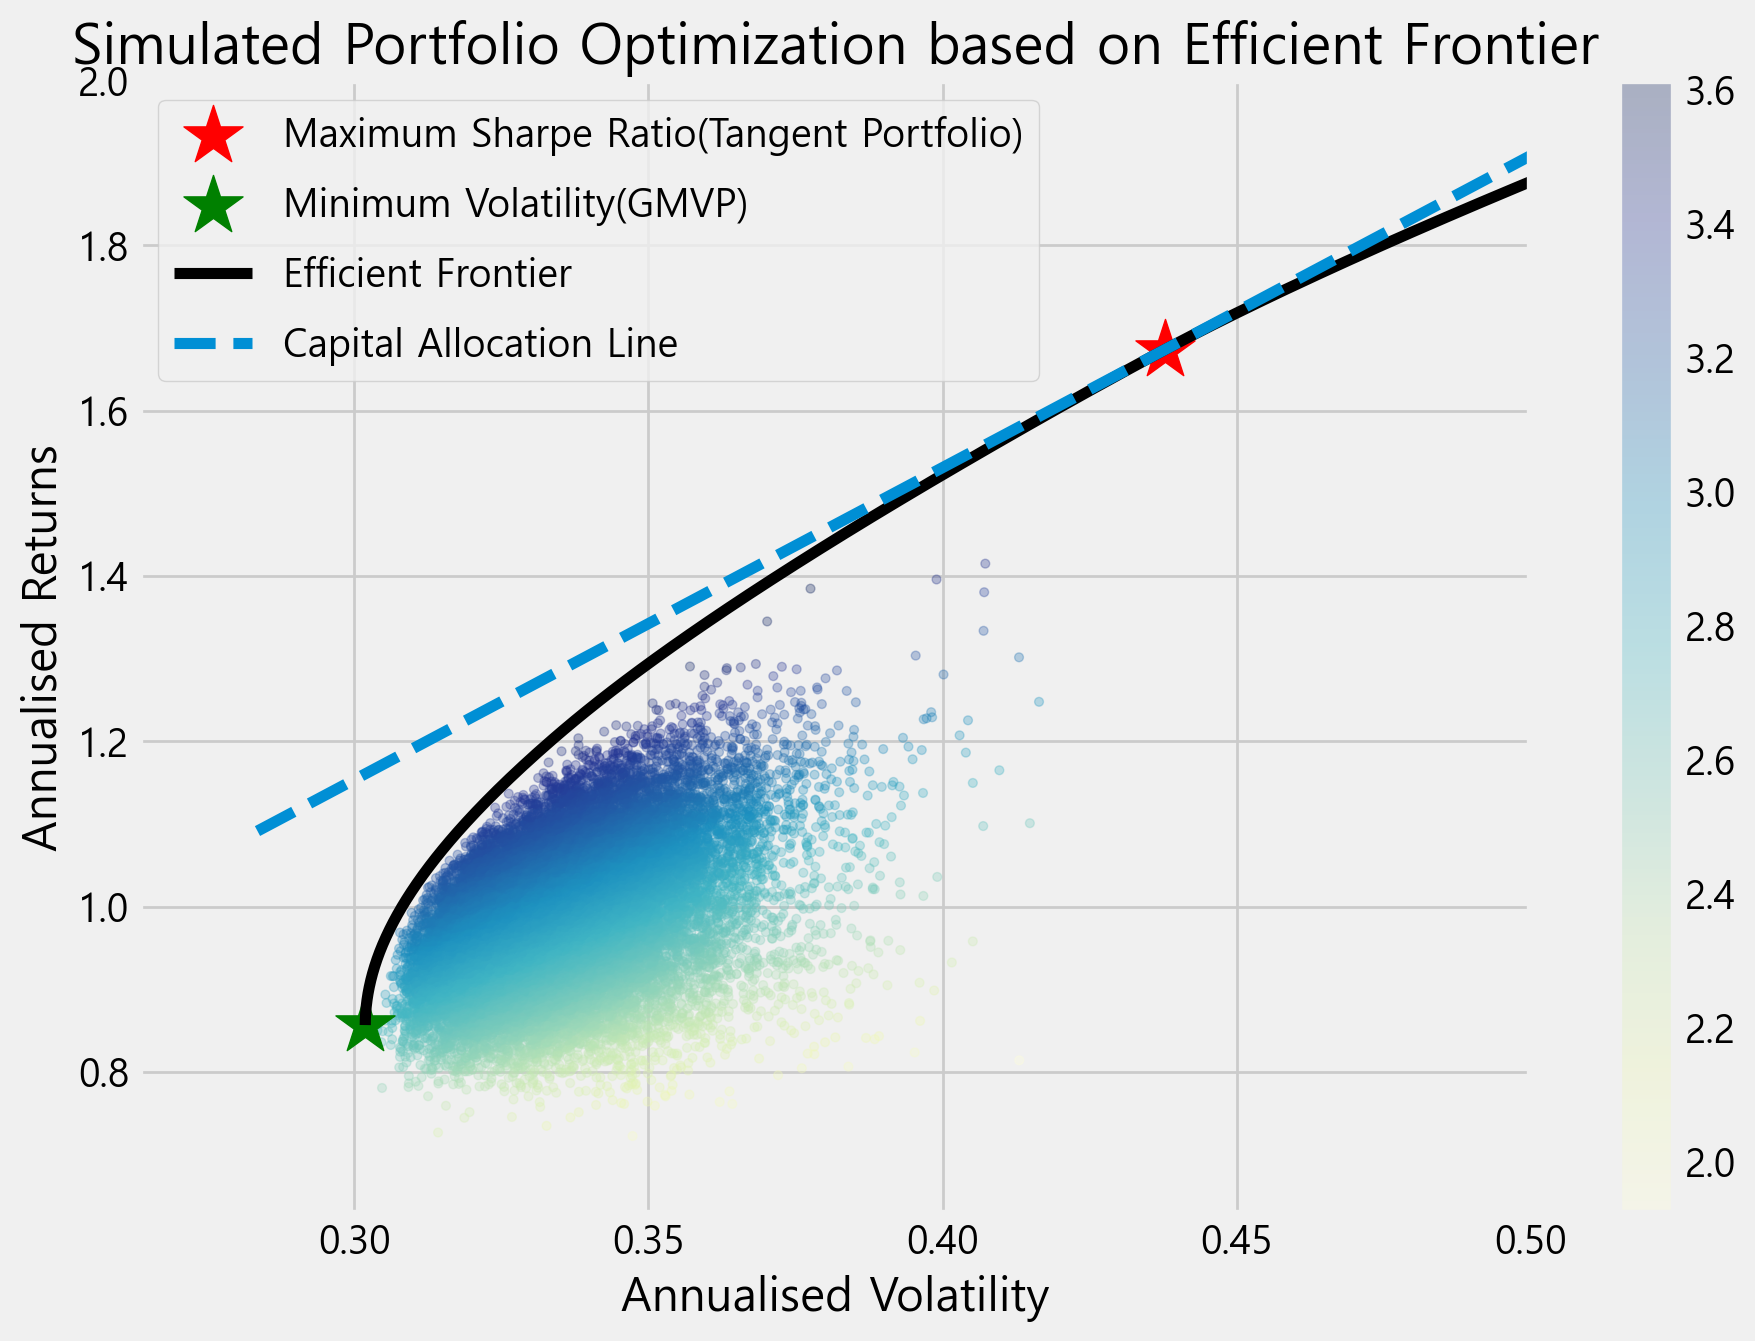

In [16]:
# When portfolio is optimized using solver
t_return, t_std = display_simulated_ef_with_line(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

<hr style="border:2px solid gray">

In [17]:
def cal_weight(u: float, A: int, variance: float, risk_free_rate: float):
    """
    Use the tangent portfolio variables to calculate weight of risky portfolio
    and risk-free investment.
    
    Args:
        u (float): expected return of tangent portfolio.
        A (int): Risk preference.
        variance (float): variance of tangent portfolio.
        risk_free_rate (float): Risk-free rate assumption.
    """
    risk_premium = u - risk_free_rate
    risk_preference = A * variance
    w1 = risk_premium/risk_preference
    w2 = 1 - w1
    
    return w1, w2

In [18]:
# 

A = 50
risk_free_rate = 0.02
cal_weight(t_return, A, t_std**2, risk_free_rate)

(0.17259537092783783, 0.8274046290721622)